In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns;
import statsmodels.api as sm 
import scipy.special
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')

from matplotlib import font_manager as fm
fm.fontManager.addfont('Arial.ttf')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

%matplotlib inline

# Setup

In [2]:
home='../../../../projects/genetwork/grn-paper'
display(glob.glob(home+'/*.*'))

networks=pd.read_csv(home+'/networks.tsv', sep='\t', index_col=0)
nets=np.arange(networks.shape[0])

edges=np.load(home+'/beta.npy', mmap_mode='r')
rna=np.load(home+'/rna.npy', mmap_mode='r')
ko=np.load(home+'/ko.npy', mmap_mode='r')
degrade=np.load(home+'/degrade.npy', mmap_mode='r')
dists=np.load(home+'/dist.npy', mmap_mode='r')
modules=np.load(home+'/module.npy', mmap_mode='r')
self = np.array([np.eye(ko.shape[-1]).astype(bool) for _ in tqdm(range(networks.shape[0]))])

for i,x in zip(['edges','rna','ko','degrade'], [edges, rna, ko, degrade]):
    print('{0} shape: {1}'.format(i, x.shape))

networks[['r','k','w','delta_in','delta_out']]=networks[['r','k','w','delta_in','delta_out']].astype(int)
display(networks.tail())

['../../../../projects/genetwork/grn-paper/ko.npy',
 '../../../../projects/genetwork/grn-paper/dist.npy',
 '../../../../projects/genetwork/grn-paper/module.npy',
 '../../../../projects/genetwork/grn-paper/degrade.npy',
 '../../../../projects/genetwork/grn-paper/networks.tsv',
 '../../../../projects/genetwork/grn-paper/rna.npy',
 '../../../../projects/genetwork/grn-paper/beta.npy',
 '../../../../projects/genetwork/grn-paper/alpha.npy']

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1920/1920 [00:23<00:00, 83.44it/s]


edges shape: (1920, 2000, 2000)
rna shape: (1920, 2000)
ko shape: (1920, 2000, 2000)
degrade shape: (1920, 2000, 1)


,files,n,k,r,delta_in,delta_out,w
1916,/oak/stanford/groups/pritch/users/magu/project...,2000,100,16,300,30,9
1917,/oak/stanford/groups/pritch/users/magu/project...,2000,100,16,300,30,40
1918,/oak/stanford/groups/pritch/users/magu/project...,2000,100,16,300,30,90
1919,/oak/stanford/groups/pritch/users/magu/project...,2000,100,16,300,30,400
1920,/oak/stanford/groups/pritch/users/magu/project...,2000,100,16,300,30,900


0.000    8.710604e-12
0.001    7.850470e-08
0.010    6.684269e-05
0.100    1.236285e-02
0.500    2.022045e-01
0.900    9.258403e-01
0.990    1.291112e+00
0.999    1.569519e+00
dtype: float64


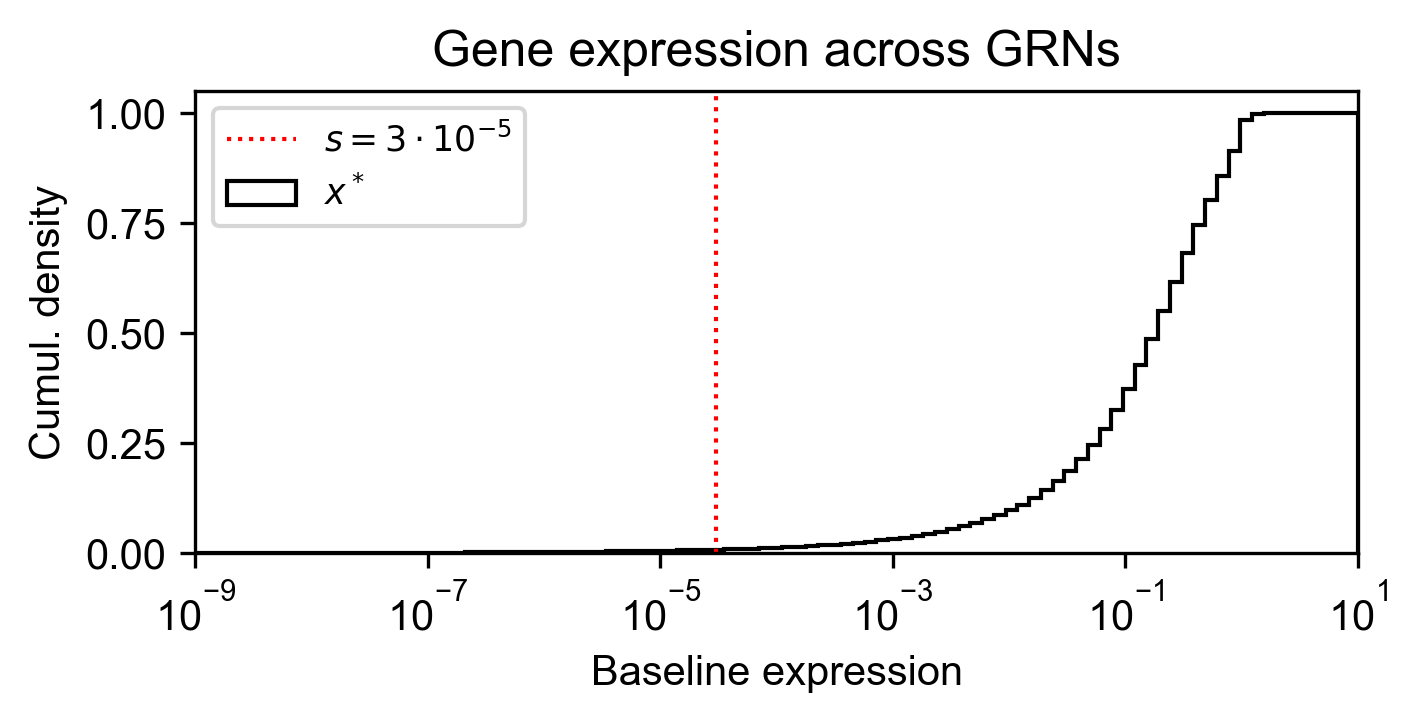

In [3]:
print(pd.Series(rna.flatten()).quantile([0, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999]))

plt.figure(figsize=(5,2), dpi=300);
plt.hist(np.clip(rna.flatten(), 1e-9, 1e1), 
         bins=np.logspace(-9,1,100),
         density=True,
         cumulative=True,
         histtype='step', 
         color='k'); 
plt.semilogx();
plt.xlabel('Baseline expression'); plt.xlim(1e-9, 1e1);
plt.ylabel('Cumul. density'); 
plt.title('Gene expression across GRNs');
plt.axvline(3e-5, color='r', linestyle='dotted', linewidth=1);
plt.legend([r'$s=3\cdot10^{-5}$', r'$x^*$'], fontsize='small', loc='upper left');

In [4]:
lowE = (rna < 1e-4)
lowE.shape, pd.Series(lowE.sum(axis=1)).describe()

((1920, 2000),
 count    1920.000000
 mean       23.317187
 std        32.320227
 min         0.000000
 25%         0.000000
 50%         7.000000
 75%        35.000000
 max       152.000000
 dtype: float64)

# On-the-fly computation

In [5]:
networks['n_highE'] = np.sum(~lowE, axis=1)

In [6]:
networks['100kos'] = [np.sum(np.sum(np.abs(ko[ix,:,:][np.ix_(~lowE[ix,:],~lowE[ix,:])]) > 1e-1, axis=0) > 99) 
                      for ix in tqdm(range(len(networks)))]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1920/1920 [01:54<00:00, 16.84it/s]


In [7]:
networks['100tgs'] = [np.sum(np.sum(np.abs(ko[ix,:,:][np.ix_(~lowE[ix,:],~lowE[ix,:])]) > 1e-1, axis=1) > 99) 
                      for ix in tqdm(range(len(networks)))]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1920/1920 [01:42<00:00, 18.69it/s]


In [8]:
networks['n_kos'] = [np.sum(np.abs(ko[ix,:,:][np.ix_(~lowE[ix,:],~lowE[ix,:])]) > 1e-1) / np.sum(~lowE[ix,:])
                     for ix in tqdm(range(len(networks)))]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1920/1920 [01:43<00:00, 18.48it/s]


# Figure 4

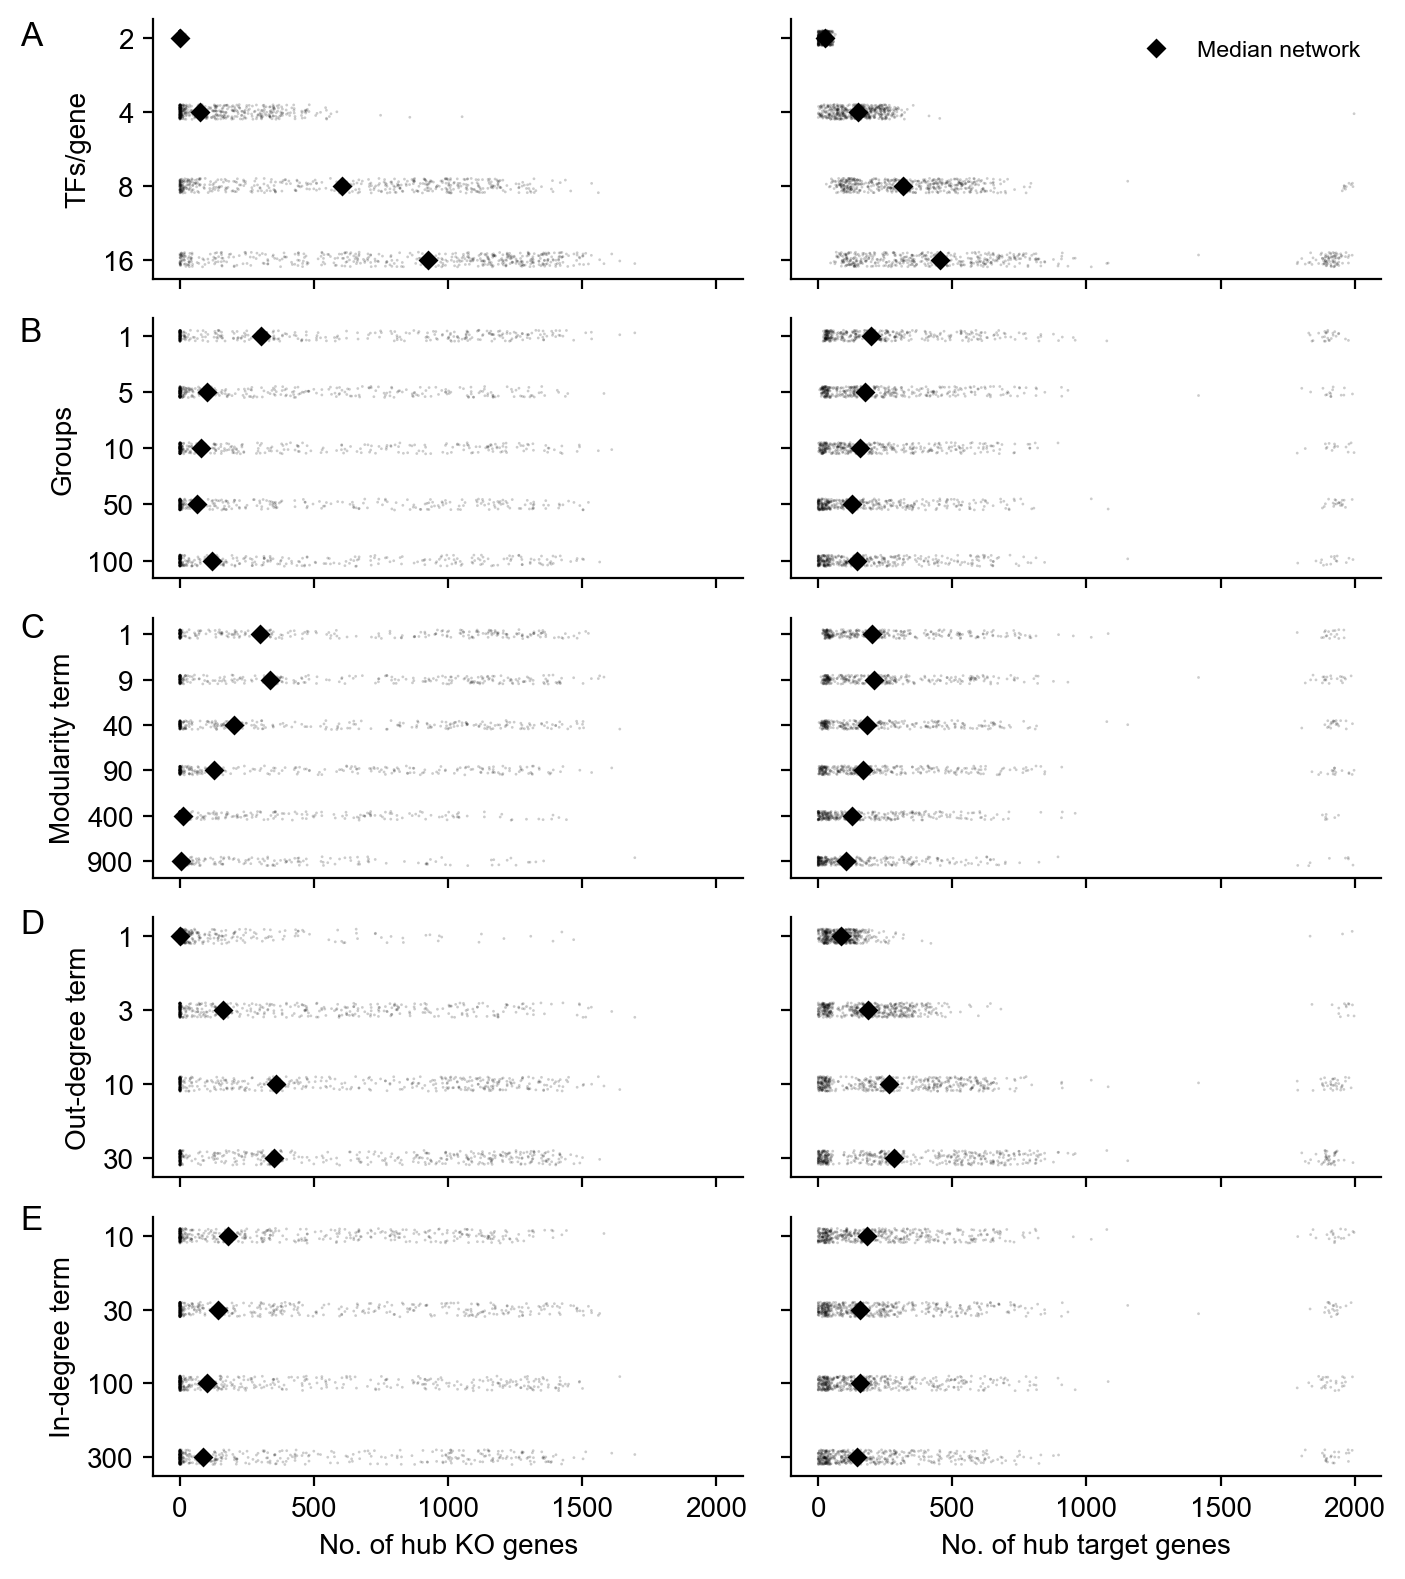

In [9]:
sns.set_style(None)

props=['r','k','w','delta_out','delta_in']
names=['TFs/gene', 'Groups', 'Modularity term', 'Out-degree term', 'In-degree term']

stats=['100kos','100tgs']
shortlabs=['No. of hub KO genes','No. of hub target genes']
statdescs=['Number of KOs having 100 effects with |logFC| > 0.1',
           'Number of TGs having 100 regulators with |logFC| > 0.1']

fig, ax = plt.subplots(len(props), len(stats), figsize=(7,8), dpi=200)
fig.set(facecolor='white')
d1, d2 = ax.shape

for i1,(prop,name) in enumerate(zip(props,names)):
    for i2,(stat, shortlab) in enumerate(zip(stats,shortlabs)):
        sns.stripplot(data = networks, 
                      x = stat, 
                      y = prop,
                      orient = 'h',
                      hue = None,
                      dodge = True,
                      alpha = 0.2, 
                      size = 1,
                      zorder = 1, 
                      color = 'k',
                      #legend = False, 
                      ax = ax[i1, i2]
        )
        ax[i1, i2].plot(*zip(*map(reversed,enumerate(networks.groupby(prop)[stat].median().values))),
                        color='k',
                        linestyle='none',
                        marker='D',
                        alpha=1.0,
                        markersize=4,
                        label=None)
        errorbars='''
        sns.pointplot(data = networks, 
                      x = stat, 
                      y = prop,
                      orient = 'h',
                      #estimator = np.mean,
                      hue = None,
                      dodge = .8 - .8 / 3,
                      errorbar = ('ci', 0.01),
                      scale = 0.9,
                      linestyles = 'none',
                      color = 'k',
                      alpha = 0.8,
                      #palette = "dark",
                      markers = 'd', 
                      ax = ax[i1, i2]
        )'''
        if i1 == len(props)-1:
            ax[i1, i2].set_xlabel(shortlab);
        else:
            ax[i1, i2].set_xlabel('');
            ax[i1, i2].set_xticklabels(['' for _ in ax[i1,i2].get_xticklabels()]);
        if i2 == 0:
            ax[i1, i2].set_ylabel(name)
        else:
            ax[i1, i2].set_ylabel('');
            ax[i1, i2].set_yticklabels(['' for _ in ax[i1,i2].get_yticklabels()]);
        ax[i1, i2].set_xlim(-100, 2100);
    
ax[0,-1].legend(['Median network'], fontsize='small', loc='upper right', frameon=False);

fig.text(-0.0, 0.98, 'A', fontsize=12, horizontalalignment='left', verticalalignment='top');
fig.text(-0.0, 0.795, 'B', fontsize=12, horizontalalignment='left', verticalalignment='top');
fig.text(-0.0, 0.61, 'C', fontsize=12, horizontalalignment='left', verticalalignment='top');
fig.text(-0.0, 0.425, 'D', fontsize=12, horizontalalignment='left', verticalalignment='top');
fig.text(-0.0, 0.24, 'E', fontsize=12, horizontalalignment='left', verticalalignment='top');

sns.despine()
fig.tight_layout(); 
plt.savefig('png/fig4.png');

# Regression analysis

In [10]:
networks['k_adj'] = networks['k'].replace({1: 2000})
networks.head()

,files,n,k,r,delta_in,delta_out,w,n_highE,100kos,100tgs,n_kos,k_adj
1,/oak/stanford/groups/pritch/users/magu/project...,2000,1,2,10,1,1,1999,0,49,12.084042,2000
2,/oak/stanford/groups/pritch/users/magu/project...,2000,1,2,10,1,9,2000,0,35,11.606500,2000
3,/oak/stanford/groups/pritch/users/magu/project...,2000,1,2,10,1,40,2000,0,26,7.267500,2000
4,/oak/stanford/groups/pritch/users/magu/project...,2000,1,2,10,1,90,2000,0,46,11.632500,2000
5,/oak/stanford/groups/pritch/users/magu/project...,2000,1,2,10,1,400,2000,0,47,12.736000,2000


\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &        y         & \textbf{  R-squared:         } &     0.587   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.586   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     543.6   \\
\textbf{Date:}             & Wed, 03 Jul 2024 & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}             &     17:27:50     & \textbf{  Log-Likelihood:    } &   -4167.4   \\
\textbf{No. Observations:} &        1920      & \textbf{  AIC:               } &     8347.   \\
\textbf{Df Residuals:}     &        1914      & \textbf{  BIC:               } &     8380.   \\
\textbf{Df Model:}         &           5      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                    & \textbf{coef} & \

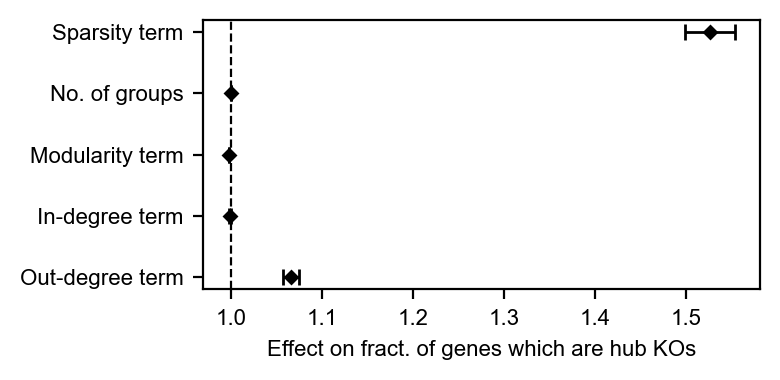

In [11]:
ko_model = sm.OLS(scipy.special.logit((networks['100kos'].clip(1, networks['n_highE']-1)) / networks['n_highE']), 
                  sm.add_constant(networks[['r','k_adj','w','delta_in','delta_out']])).fit()
print(ko_model.summary().as_latex())
print(ko_model.pvalues)

odds = ko_model.conf_int().rename(columns={0:'2.5%', 1:'97.5%'})
odds['Odds Ratio'] = ko_model.params
odds = np.exp(odds.drop('const').rename(index={'r':'Sparsity term',
                                               'k_adj':'No. of groups',
                                               'w':'Modularity term',
                                               'delta_in':'In-degree term',
                                               'delta_out':'Out-degree term'}))
ci = [odds.iloc[::-1]['Odds Ratio'] - odds.iloc[::-1]['2.5%'].values, 
      odds.iloc[::-1]['97.5%'].values - odds.iloc[::-1]['Odds Ratio']]


plt.figure(figsize=(4, 2), dpi=200)

plt.errorbar(x=odds.iloc[::-1]['Odds Ratio'], 
             y=odds.iloc[::-1].index.values, 
             xerr=ci,
             color='black', capsize=3, linestyle='None', linewidth=1,
             marker="D", markersize=3, mfc="black", mec="black")

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Effect on fract. of genes which are hub KOs', fontsize=8)
plt.tight_layout()
plt.savefig('png/supplement/fig_s4d.png')

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &        y         & \textbf{  R-squared:         } &     0.461   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.460   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     327.7   \\
\textbf{Date:}             & Wed, 03 Jul 2024 & \textbf{  Prob (F-statistic):} & 6.30e-254   \\
\textbf{Time:}             &     17:27:51     & \textbf{  Log-Likelihood:    } &   -3973.5   \\
\textbf{No. Observations:} &        1920      & \textbf{  AIC:               } &     7959.   \\
\textbf{Df Residuals:}     &        1914      & \textbf{  BIC:               } &     7992.   \\
\textbf{Df Model:}         &           5      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                    & \textbf{coef} & \

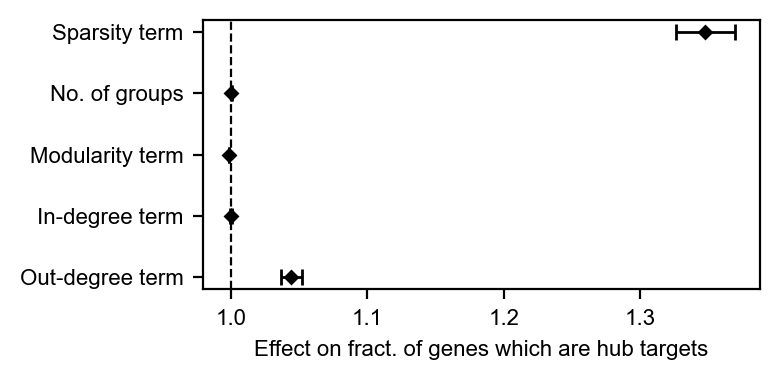

In [12]:
ko_model = sm.OLS(scipy.special.logit((networks['100tgs'].clip(1, networks['n_highE']-1)) / networks['n_highE']), 
                  sm.add_constant(networks[['r','k_adj','w','delta_in','delta_out']])).fit()

print(ko_model.summary().as_latex())
print(ko_model.pvalues)

odds = ko_model.conf_int().rename(columns={0:'2.5%', 1:'97.5%'})
odds['Odds Ratio'] = ko_model.params
odds = np.exp(odds.drop('const').rename(index={'r':'Sparsity term',
                                               'k_adj':'No. of groups',
                                               'w':'Modularity term',
                                               'delta_in':'In-degree term',
                                               'delta_out':'Out-degree term'}))
ci = [odds.iloc[::-1]['Odds Ratio'] - odds.iloc[::-1]['2.5%'].values, 
      odds.iloc[::-1]['97.5%'].values - odds.iloc[::-1]['Odds Ratio']]


plt.figure(figsize=(4, 2), dpi=200)

plt.errorbar(x=odds.iloc[::-1]['Odds Ratio'], 
             y=odds.iloc[::-1].index.values, 
             xerr=ci,
             color='black', capsize=3, linestyle='None', linewidth=1,
             marker="D", markersize=3, mfc="black", mec="black")

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Effect on fract. of genes which are hub targets', fontsize=8)
plt.tight_layout()
plt.savefig('png/supplement/fig_s4e.png')

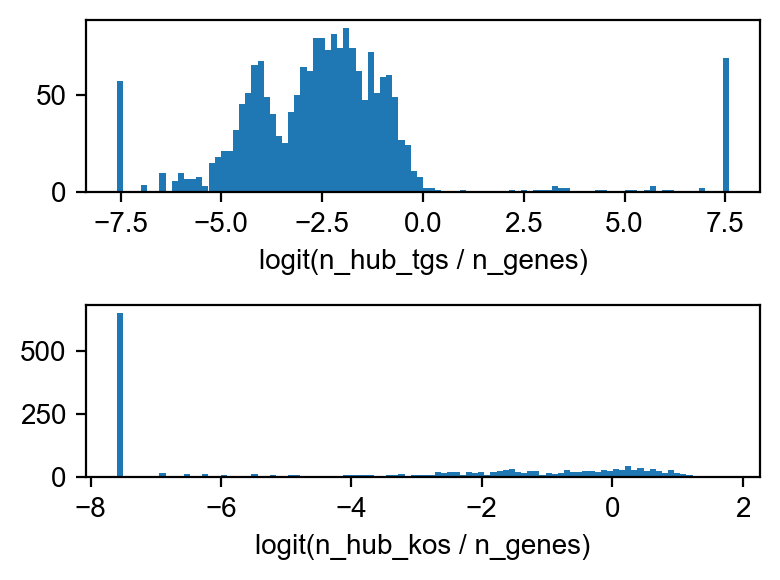

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3), dpi=200)

ax[0].hist(scipy.special.logit((networks['100tgs'].clip(1, networks['n_highE']-1)) / networks['n_highE']), bins=100);
ax[0].set_xlabel('logit(n_hub_tgs / n_genes)')

ax[1].hist(scipy.special.logit((networks['100kos'].clip(1, networks['n_highE']-1)) / networks['n_highE']), bins=100);
ax[1].set_xlabel('logit(n_hub_kos / n_genes)');

fig.tight_layout()

# Supplement

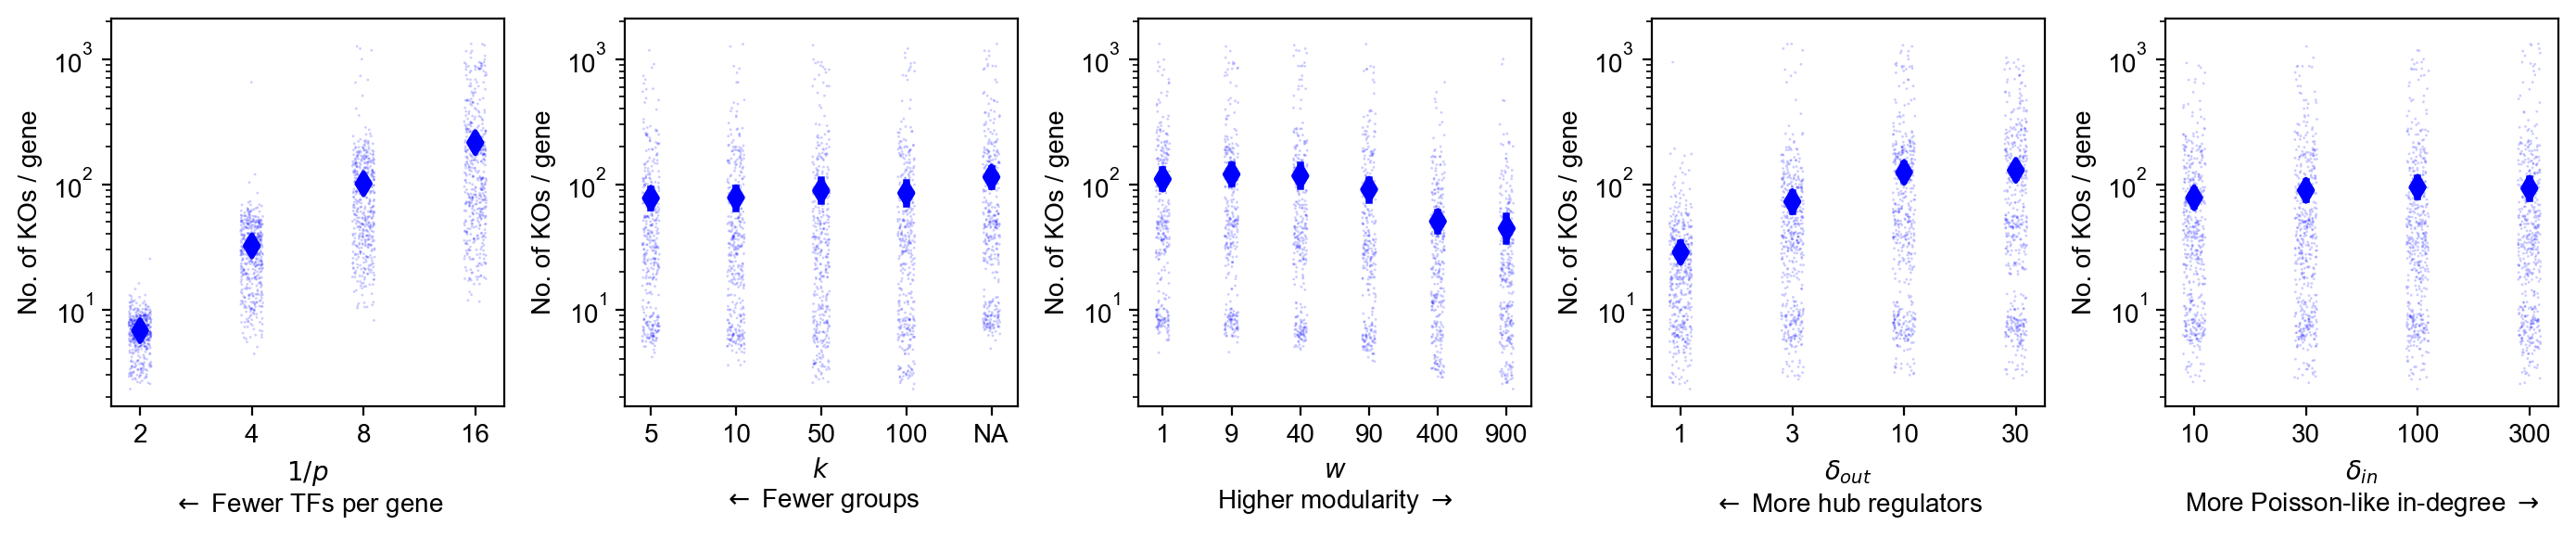

In [14]:
sns.set_style(None)


props=['r','k_adj','w','delta_out','delta_in']

names=[r'$1/p$'+'\n'+r'$\leftarrow$'+' Fewer TFs per gene', 
       r'$k$'+'\n'+r'$\leftarrow$'+' Fewer groups', 
       r'$w$'+'\nHigher modularity '+r'$\rightarrow$', 
       r'$\delta_{out}$'+'\n'+r'$\leftarrow$'+' More hub regulators',
       r'$\delta_{in}$'+'\nMore Poisson-like in-degree '+r'$\rightarrow$',
]

stats=['n_kos']
shortlabs=['No. of KOs / gene']
statdescs=['Number of KOs per gene, with |logFC| > 0.1']

fig, ax = plt.subplots(len(stats), len(props), figsize=(14,3), dpi=200)
fig.set(facecolor='white')
d1, d2 = len(props), len(stats)
ax = ax.reshape(1,-1)

for i2,(prop,name) in enumerate(zip(props,names)):
    for i1,(stat, shortlab) in enumerate(zip(stats,shortlabs)):
        sns.stripplot(data = networks, 
                      y = stat, 
                      x = prop,
                      orient = 'v',
                      hue = 'delta_out' if prop not in ['delta_out', 'r','w','k_adj','delta_in'] else None,
                      dodge = True,
                      alpha = 0.2, 
                      size = 1,
                      zorder = 1, 
                      color = 'b',
                      ax = ax[i1, i2]
        )
        sns.pointplot(data = networks, 
                      y = stat, 
                      x = prop,
                      orient = 'v',
                      estimator = np.mean,
                      hue = 'delta_out' if prop not in ['delta_out', 'r','w','k_adj','delta_in'] else None,
                      dodge = .8 - .8 / 3,
                      errorbar = ('ci', 0.95),
                      scale = 0.9,
                      linestyles = 'none',
                      color = 'b',
                      #palette = "dark",
                      markers = 'd', 
                      ax = ax[i1, i2]
        )
        if prop == 'k_adj':
            ax[i1,i2].set_xticklabels([l if l.get_text() != '2000' else 'NA' for l in ax[i1,i2].get_xticklabels()]);
        #ax[i1,i2].legend();
        #if i2 == len(props)-1:
        ax[i1, i2].set_xlabel(name);
        ax[i1, i2].semilogy();
        #    ax[i1, i2].set_ylabel(shortlab if i1==0 else '');
        #else:
        #    ax[i1, i2].set_ylabel('');
        #    ax[i1, i2].set_yticklabels(['' for _ in ax[i1,i2].get_xticklabels()]);
        if i2 == 0 or True:
            ax[i1, i2].set_ylabel(shortlab)
        else:
            ax[i1, i2].set_ylabel('');
            ax[i1, i2].set_yticklabels(['' for _ in ax[i1,i2].get_yticklabels()]);
        ax[i1, i2].set_ylim(-100, 2100);
    
#ax[0,-1].legend(['Networks'], fontsize='small', loc='upper right');



fig.tight_layout();
plt.savefig('png/supplement/fig_s4a.png');

No handles with labels found to put in legend.
No handles with labels found to put in legend.


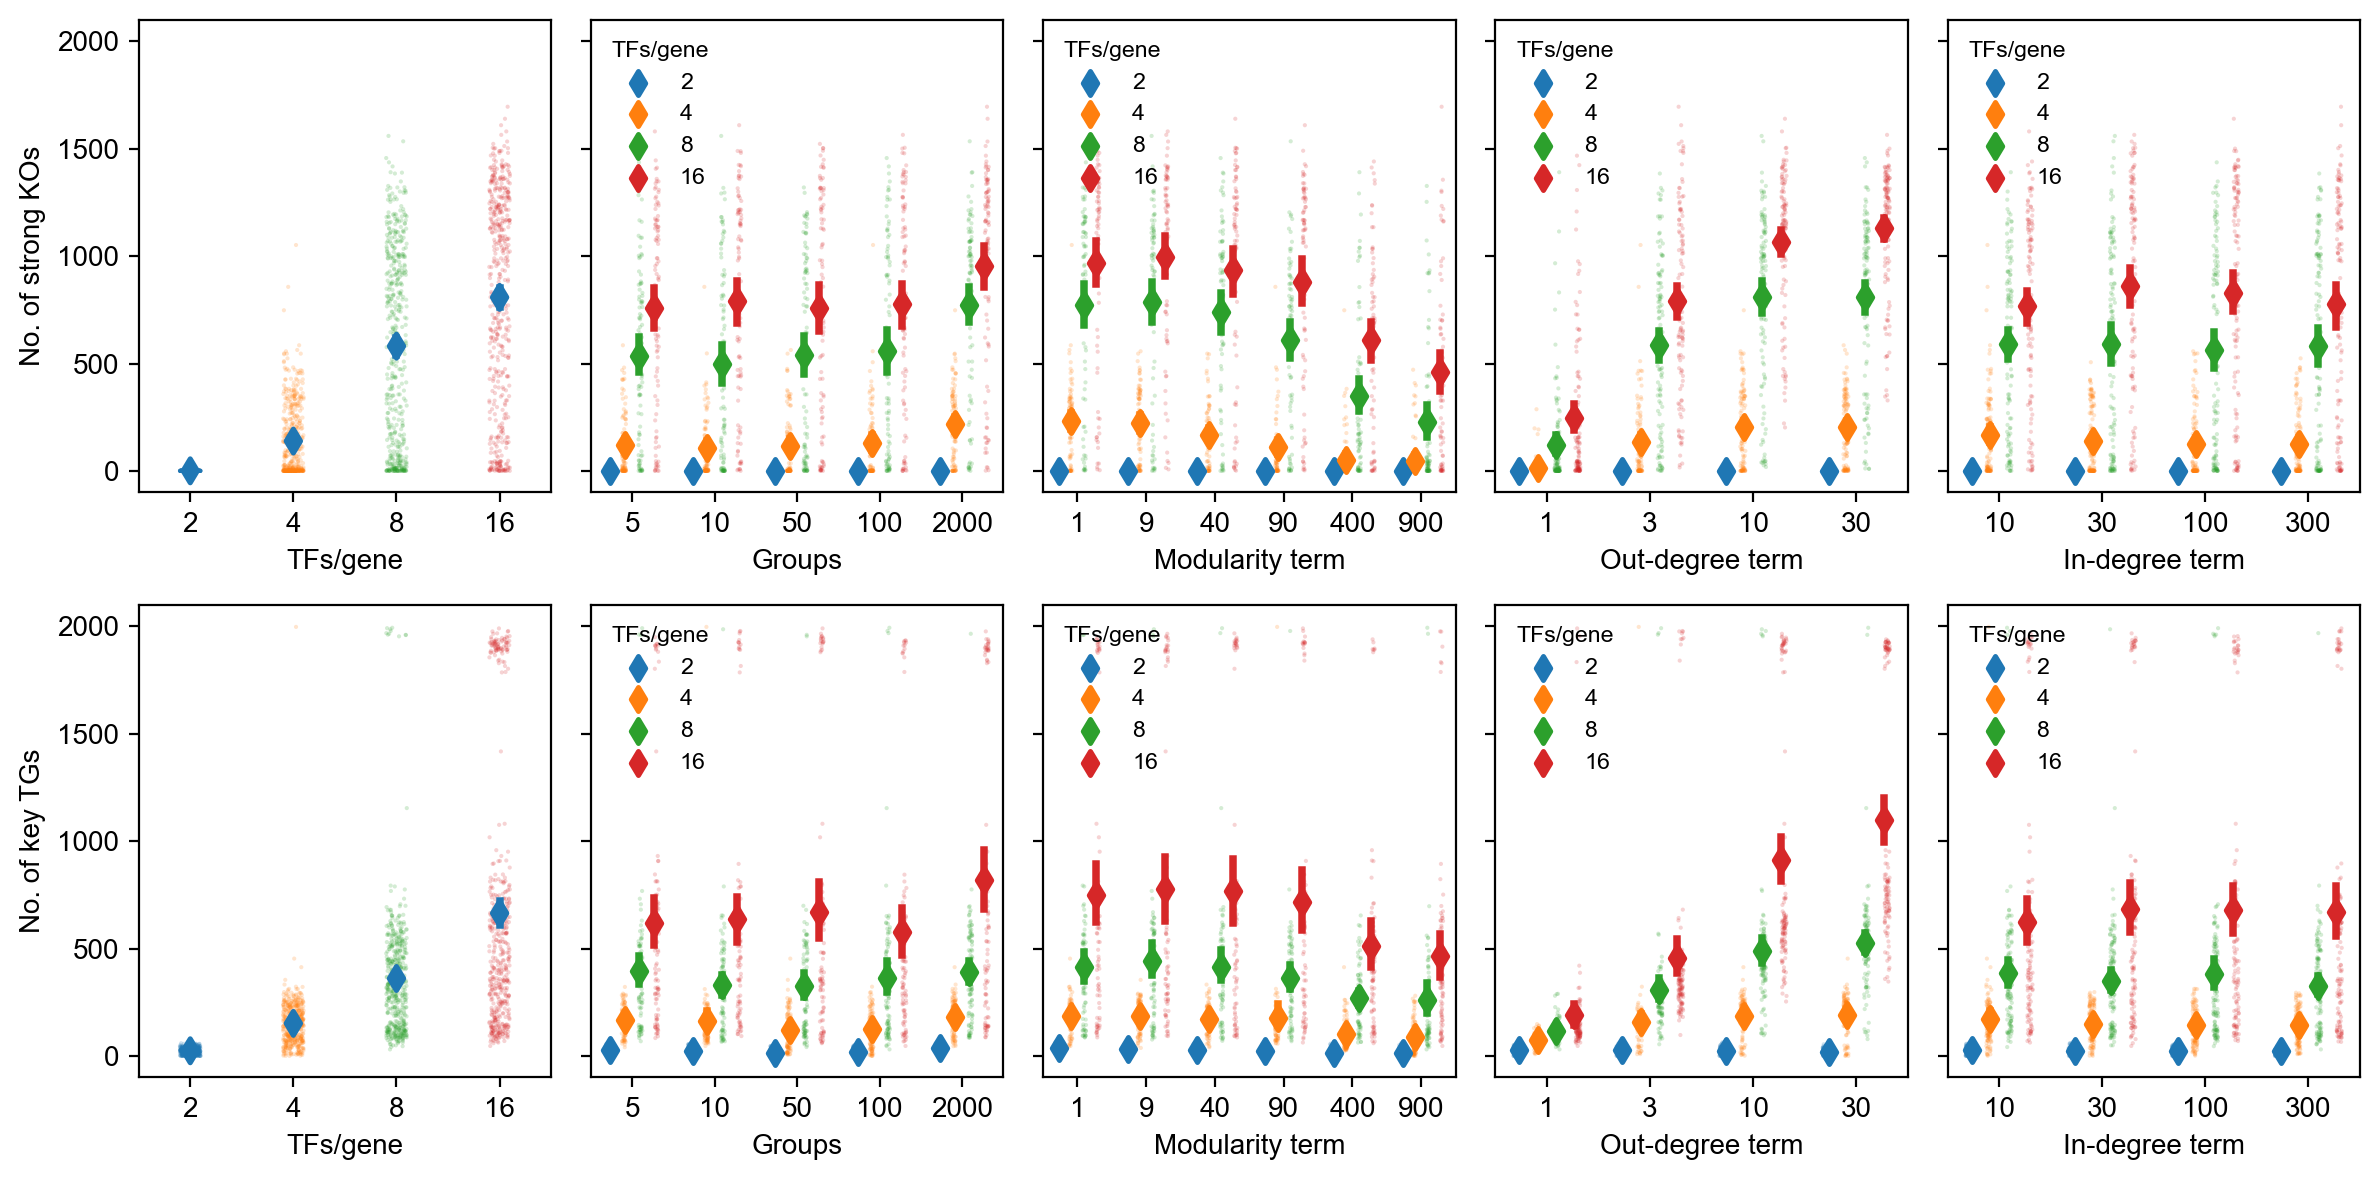

In [15]:
sns.set_style(None)

networks['k_repl'] = networks['k'].replace({1: 'NA'})

props=['r','k_adj','w','delta_out','delta_in']
names=['TFs/gene', 'Groups', 'Modularity term', 'Out-degree term', 'In-degree term']

stats=['100kos','100tgs']
shortlabs=['No. of strong KOs','No. of key TGs']
statdescs=['Number of KOs having 100 effects with |logFC| > 0.1',
           'Number of TGs having 100 regulators with |logFC| > 0.1']

fig, ax = plt.subplots(len(stats), len(props), figsize=(12,6), dpi=200)
fig.set(facecolor='white')
d1, d2 = ax.shape

for i2,(prop,name) in enumerate(zip(props,names)):
    for i1,(stat, shortlab) in enumerate(zip(stats,shortlabs)):
        sns.stripplot(data = networks, 
                      y = stat, 
                      x = prop,
                      orient = 'v',
                      hue = 'r' if prop in ['delta_out','w','k_adj','delta_in'] else None,
                      dodge = True,
                      alpha = 0.2, 
                      size = 1.5,
                      zorder = 1, 
                      #color = 'k',
                      #legend = False, 
                      ax = ax[i1, i2]
        )
        sns.pointplot(data = networks, 
                      y = stat, 
                      x = prop,
                      orient = 'v',
                      estimator = np.mean,
                      hue = 'r' if prop in ['delta_out','w','k_adj','delta_in'] else None,
                      dodge = .8 - .8 / 3,
                      errorbar = ('ci', 0.95),
                      scale = 0.9,
                      linestyles = 'none',
                      color = None,
                      #palette = "dark",
                      markers = 'd', 
                      ax = ax[i1, i2]
        )
        ax[i1, i2].set_xlabel(name);
        if i2 == 0:
            ax[i1, i2].set_ylabel(shortlab)
        else:
            ax[i1, i2].set_ylabel('');
            ax[i1, i2].set_yticklabels(['' for _ in ax[i1,i2].get_yticklabels()]);
        ax[i1, i2].set_ylim(-100, 2100);
        if prop != 'r':
            ax[i1, i2].legend(*map(lambda l: l[4:], ax[i1,i2].get_legend_handles_labels()), 
                              title='TFs/gene', fontsize='small', title_fontsize='small', loc='upper left', frameon=False)
        else:
            ax[i1, i2].legend().set_visible(False)
    

fig.tight_layout();
plt.savefig('png/supplement/fig_s4b.png');

No handles with labels found to put in legend.
No handles with labels found to put in legend.


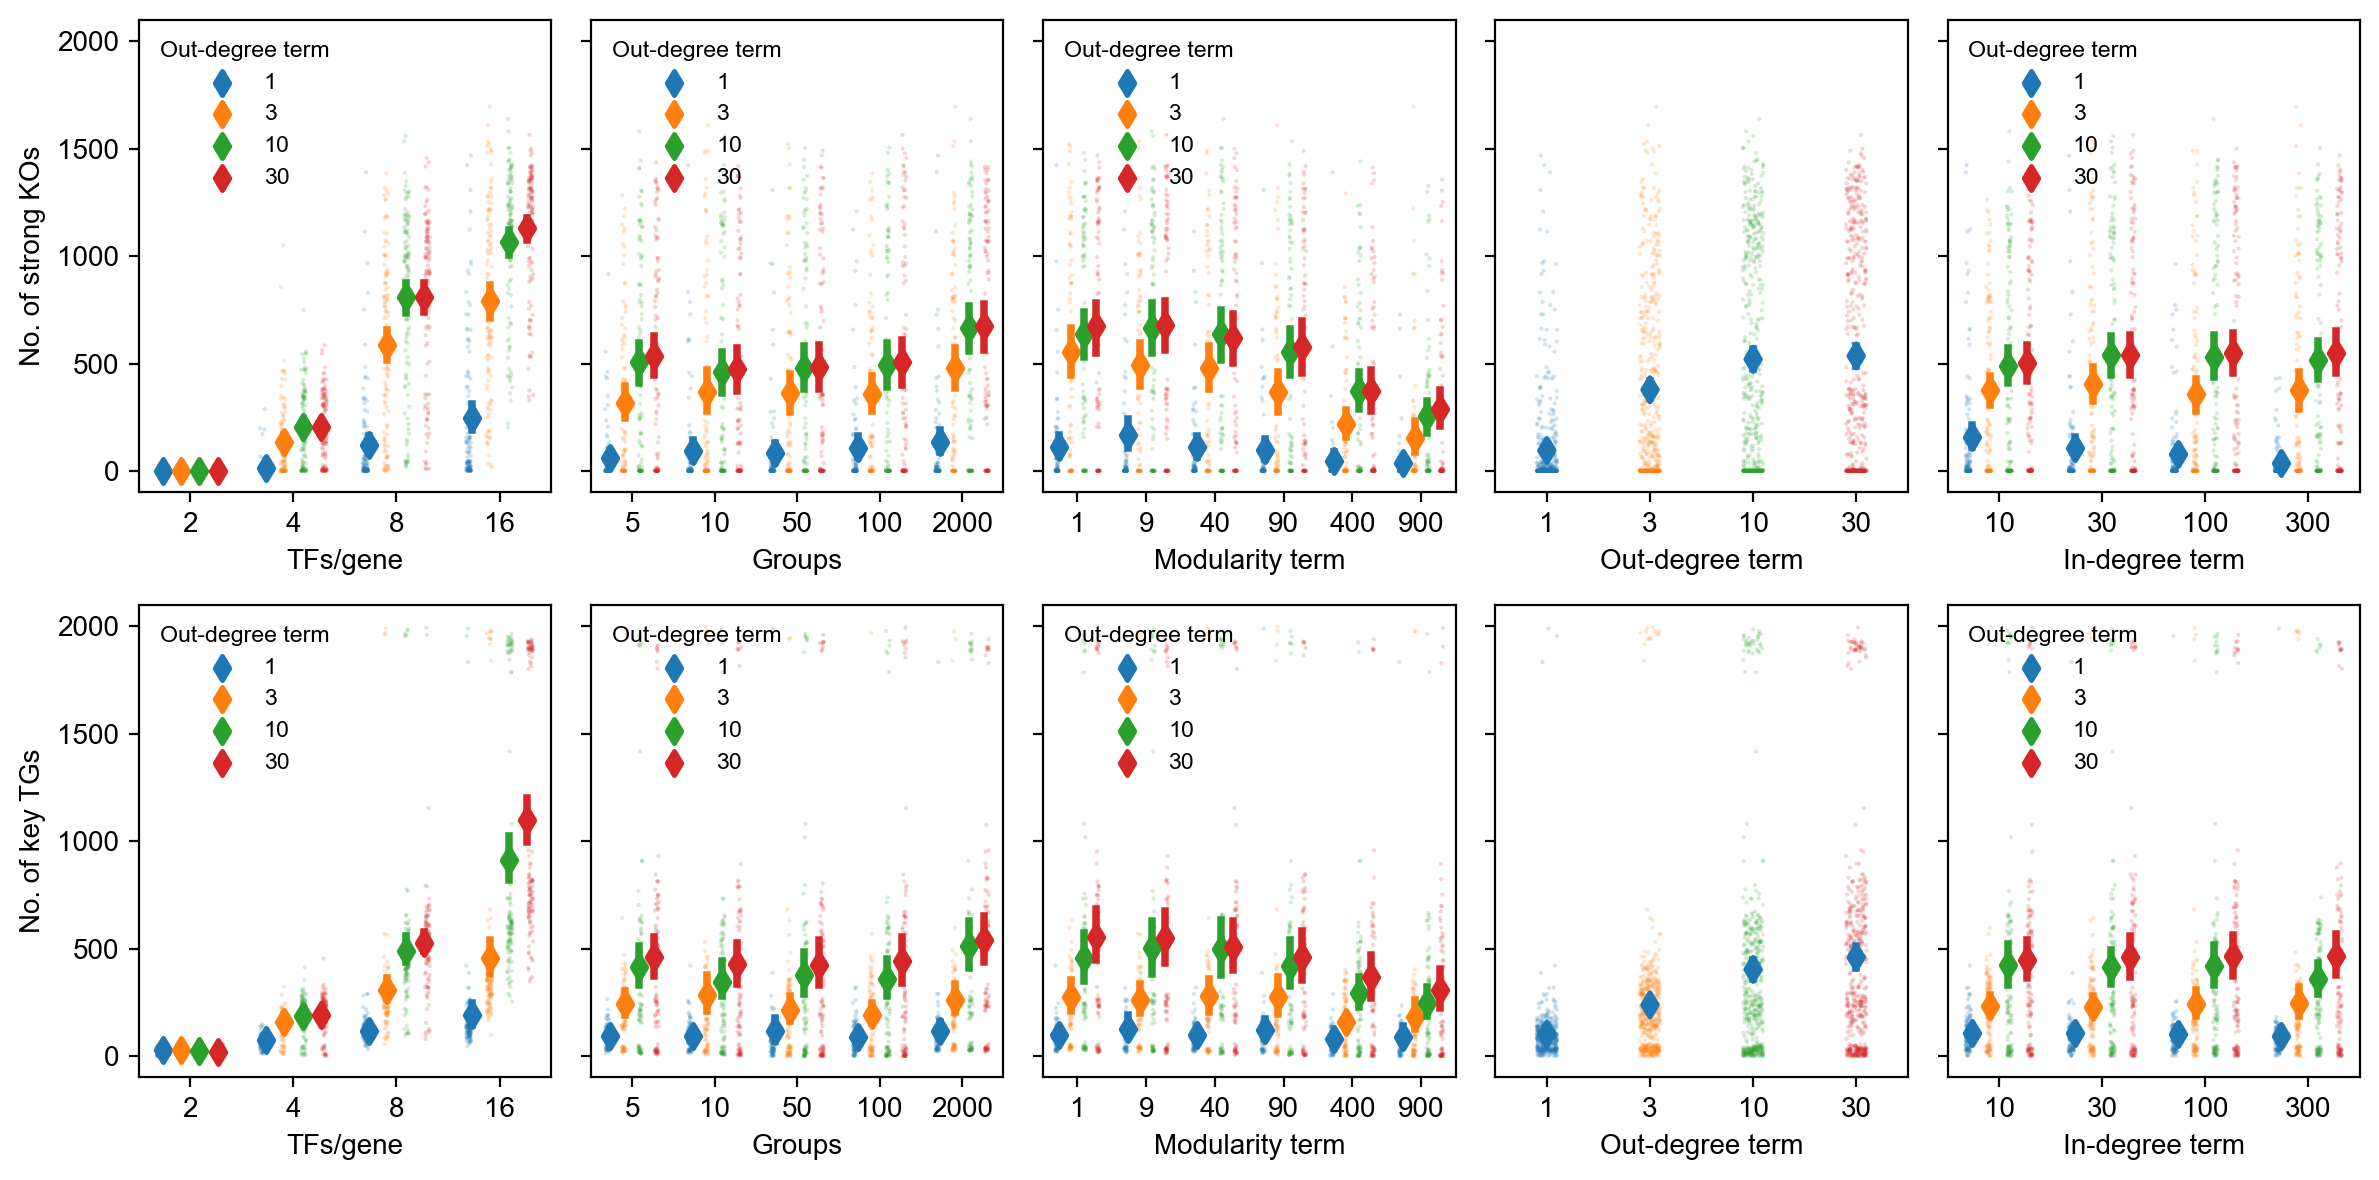

In [16]:
sns.set_style(None)

networks['k_repl'] = networks['k'].replace({1: 'NA'})

props=['r','k_adj','w','delta_out','delta_in']
names=['TFs/gene', 'Groups', 'Modularity term', 'Out-degree term', 'In-degree term']

stats=['100kos','100tgs']
shortlabs=['No. of strong KOs','No. of key TGs']
statdescs=['Number of KOs having 100 effects with |logFC| > 0.1',
           'Number of TGs having 100 regulators with |logFC| > 0.1']

fig, ax = plt.subplots(len(stats), len(props), figsize=(12,6), dpi=200)
fig.set(facecolor='white')
d1, d2 = ax.shape

for i2,(prop,name) in enumerate(zip(props,names)):
    for i1,(stat, shortlab) in enumerate(zip(stats,shortlabs)):
        sns.stripplot(data = networks, 
                      y = stat, 
                      x = prop,
                      orient = 'v',
                      hue = 'delta_out' if prop in ['r','w','k_adj','delta_in'] else None,
                      dodge = True,
                      alpha = 0.2, 
                      size = 1.5,
                      zorder = 1, 
                      #color = 'k',
                      #legend = False, 
                      ax = ax[i1, i2]
        )
        sns.pointplot(data = networks, 
                      y = stat, 
                      x = prop,
                      orient = 'v',
                      estimator = np.mean,
                      hue = 'delta_out' if prop in ['r','w','k_adj','delta_in'] else None,
                      dodge = .8 - .8 / 3,
                      errorbar = ('ci', 0.95),
                      scale = 0.9,
                      linestyles = 'none',
                      color = None,
                      legend = False,
                      markers = 'd', 
                      ax = ax[i1, i2]
        )
        ax[i1, i2].set_xlabel(name);
        if i2 == 0:
            ax[i1, i2].set_ylabel(shortlab)
        else:
            ax[i1, i2].set_ylabel('');
            ax[i1, i2].set_yticklabels(['' for _ in ax[i1,i2].get_yticklabels()]);
        ax[i1, i2].set_ylim(-100, 2100);
        if prop != 'delta_out':
            ax[i1, i2].legend(*map(lambda l: l[4:], ax[i1,i2].get_legend_handles_labels()), frameon=False,
                              title='Out-degree term', fontsize='small', title_fontsize='small', loc='upper left')
        else:
            ax[i1,i2].legend().set_visible(False)

fig.tight_layout();
plt.savefig('png/supplement/fig_s4c.png');

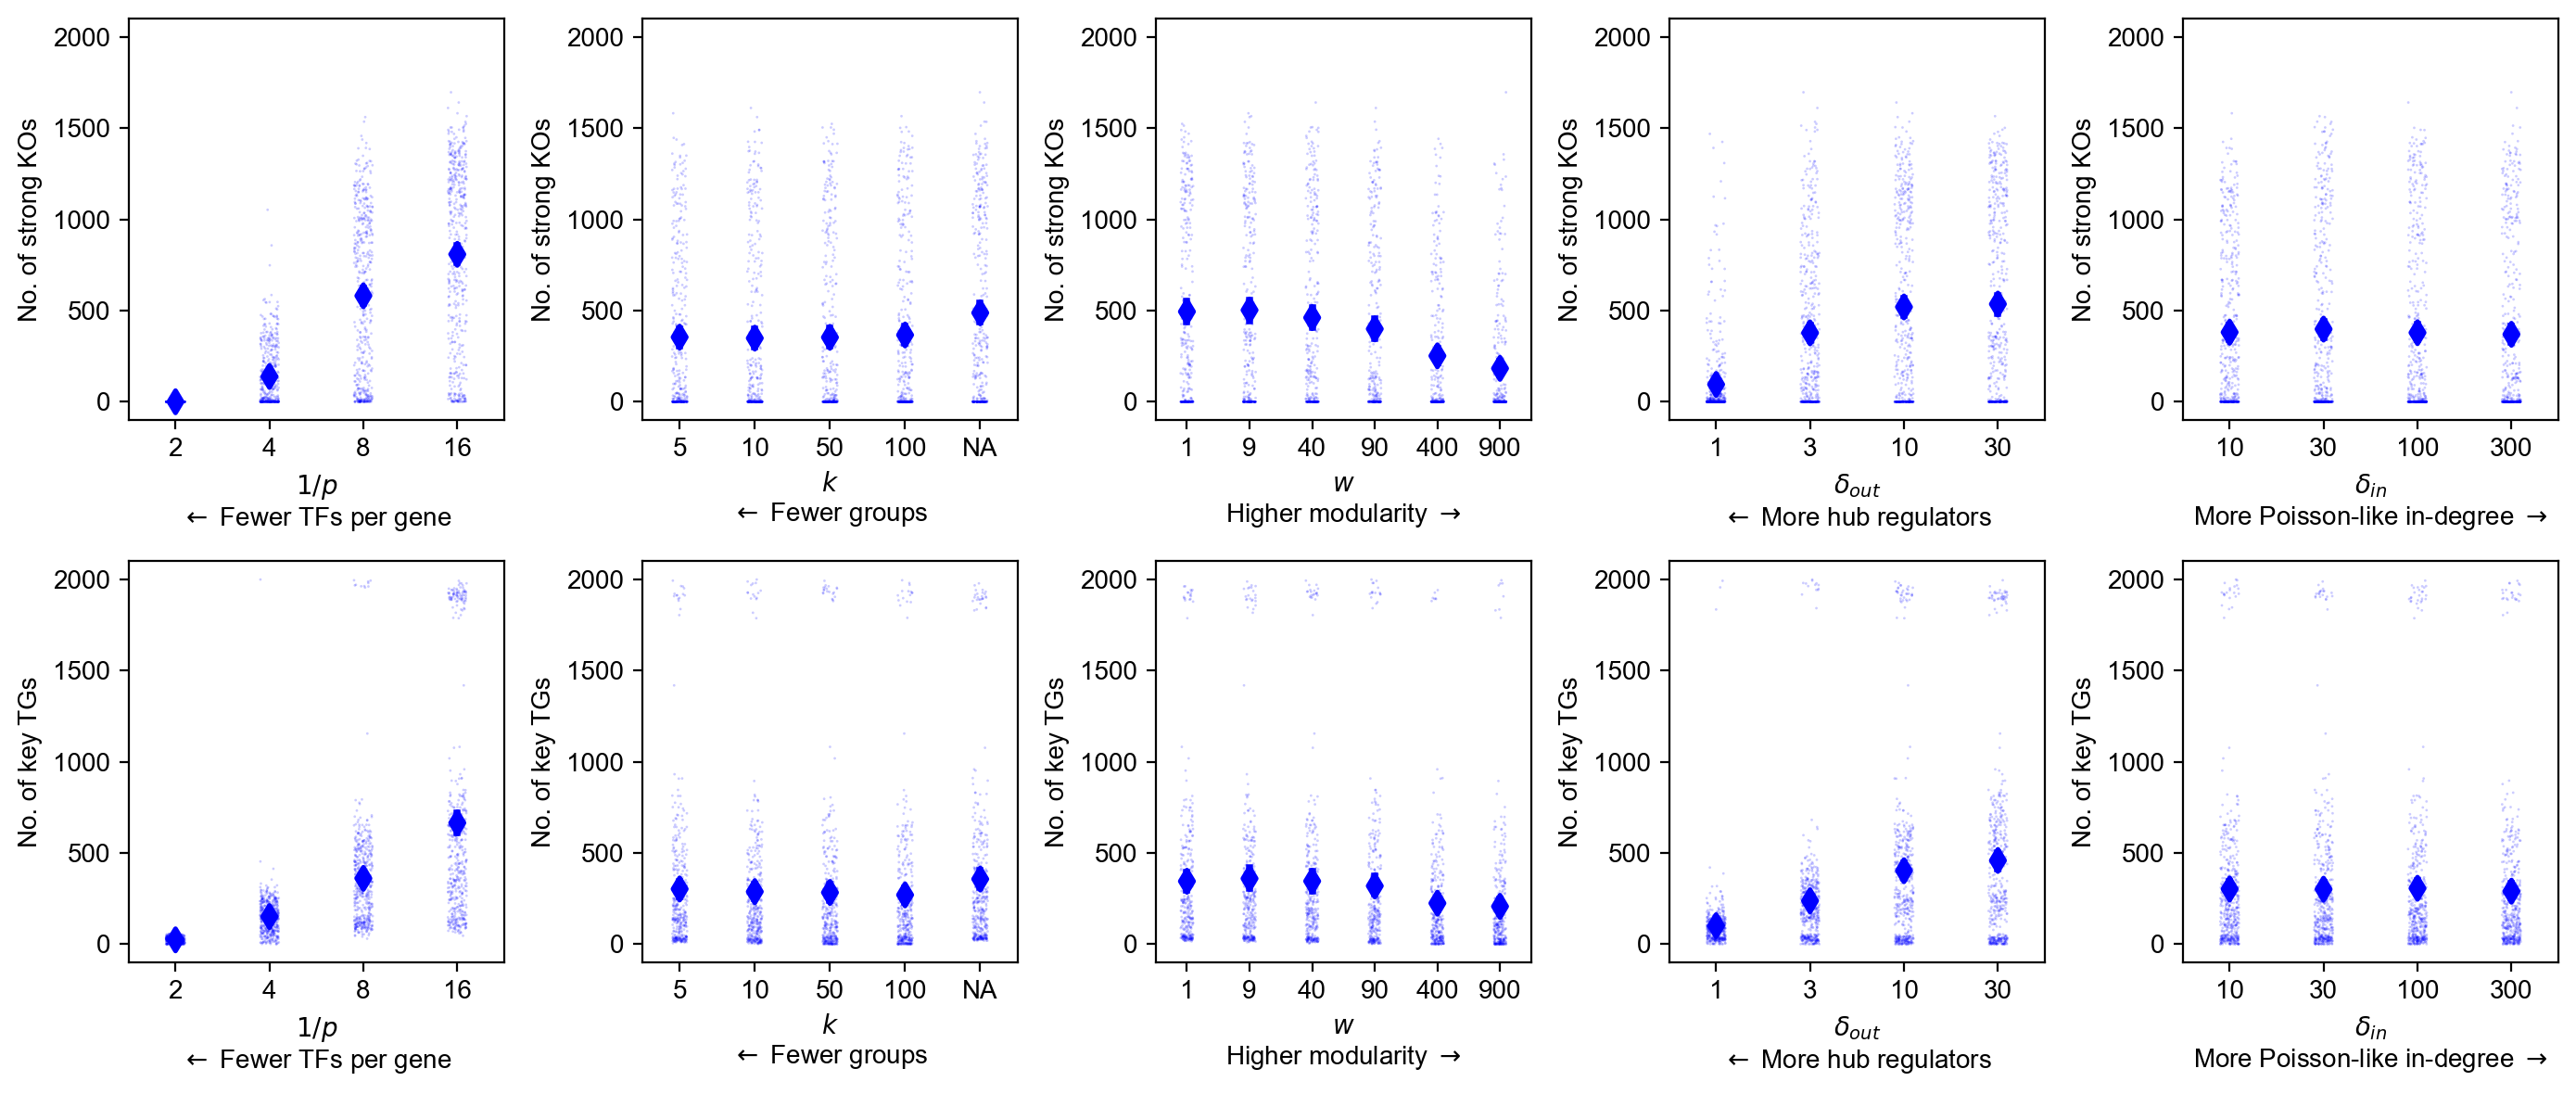

In [17]:
sns.set_style(None)

networks['k_repl'] = networks['k'].replace({1: 'NA'})

props=['r','k_adj','w','delta_out','delta_in']

names=[r'$1/p$'+'\n'+r'$\leftarrow$'+' Fewer TFs per gene', 
       r'$k$'+'\n'+r'$\leftarrow$'+' Fewer groups', 
       r'$w$'+'\nHigher modularity '+r'$\rightarrow$', 
       r'$\delta_{out}$'+'\n'+r'$\leftarrow$'+' More hub regulators',
       r'$\delta_{in}$'+'\nMore Poisson-like in-degree '+r'$\rightarrow$',
]

stats=['100kos','100tgs']
shortlabs=['No. of strong KOs','No. of key TGs']
statdescs=['Number of KOs having 100 effects with |logFC| > 0.1',
           'Number of TGs having 100 regulators with |logFC| > 0.1']

fig, ax = plt.subplots(len(stats), len(props), figsize=(14,6), dpi=200)
fig.set(facecolor='white')
d1, d2 = ax.shape

for i2,(prop,name) in enumerate(zip(props,names)):
    for i1,(stat, shortlab) in enumerate(zip(stats,shortlabs)):
        sns.stripplot(data = networks, 
                      y = stat, 
                      x = prop,
                      orient = 'v',
                      hue = 'delta_out' if prop not in ['delta_out', 'r','w','k_adj','delta_in'] else None,
                      dodge = True,
                      alpha = 0.2, 
                      size = 1,
                      zorder = 1, 
                      color = 'b',
                      ax = ax[i1, i2]
        )
        sns.pointplot(data = networks, 
                      y = stat, 
                      x = prop,
                      orient = 'v',
                      estimator = np.mean,
                      hue = 'delta_out' if prop not in ['delta_out', 'r','w','k_adj','delta_in'] else None,
                      dodge = .8 - .8 / 3,
                      errorbar = ('ci', 0.95),
                      scale = 0.9,
                      linestyles = 'none',
                      color = 'b',
                      #palette = "dark",
                      markers = 'd', 
                      ax = ax[i1, i2]
        )
        if prop == 'k_adj':
            ax[i1,i2].set_xticklabels([l if l.get_text() != '2000' else 'NA' for l in ax[i1,i2].get_xticklabels()]);
        ax[i1, i2].set_xlabel(name);
        if i2 == 0 or True:
            ax[i1, i2].set_ylabel(shortlab)
        else:
            ax[i1, i2].set_ylabel('');
            ax[i1, i2].set_yticklabels(['' for _ in ax[i1,i2].get_yticklabels()]);
        ax[i1, i2].set_ylim(-100, 2100);
    
fig.tight_layout();

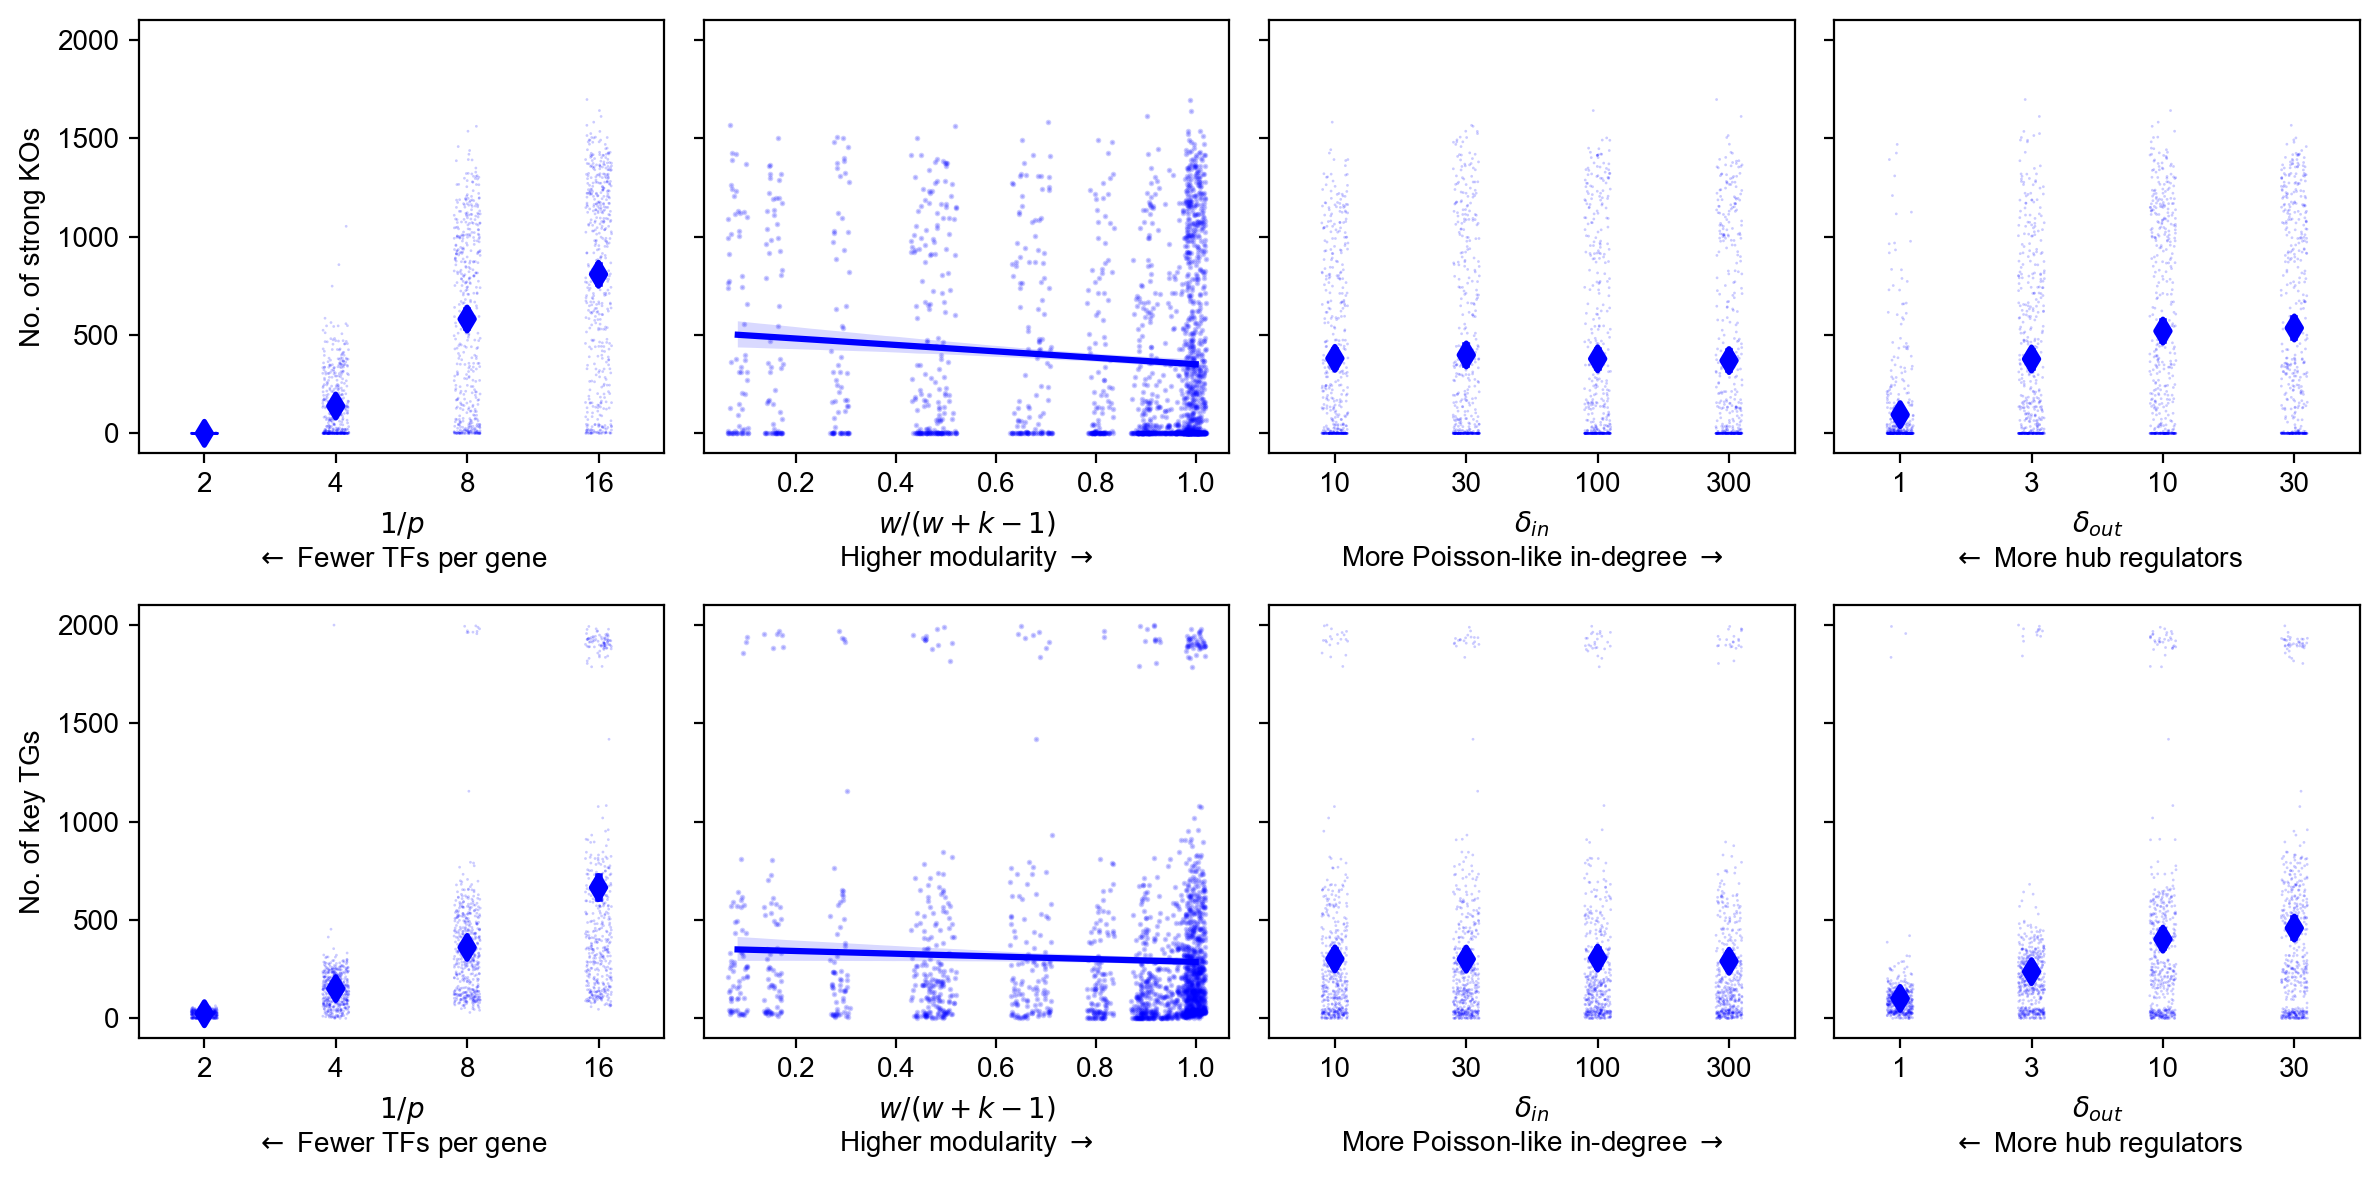

In [18]:
sns.set_style(None)

networks['wwk'] = (networks['w'] / (networks['w'] + networks['k'] - 1))
networks.loc[(networks['w']==1) | (networks['w']==1), 'wwk'] = 1

props=['r','wwk','delta_in','delta_out']
names=[r'$1/p$'+'\n'+r'$\leftarrow$'+' Fewer TFs per gene', 
       r'$w/(w+k-1)$'+'\nHigher modularity '+r'$\rightarrow$', 
       r'$\delta_{in}$'+'\nMore Poisson-like in-degree '+r'$\rightarrow$',
       r'$\delta_{out}$'+'\n'+r'$\leftarrow$'+' More hub regulators']

stats=['100kos','100tgs']
shortlabs=['No. of strong KOs','No. of key TGs']
statdescs=['Number of KOs having 100 effects with |logFC| > 0.1',
           'Number of TGs having 100 regulators with |logFC| > 0.1']

fig, ax = plt.subplots(len(stats), len(props), figsize=(12,6), dpi=200)
fig.set(facecolor='white')
d1, d2 = ax.shape

for i2,(prop,name) in enumerate(zip(props,names)):
    for i1,(stat, shortlab) in enumerate(zip(stats,shortlabs)):
        if prop != 'wwk':
            sns.stripplot(data = networks, 
                          y = stat, 
                          x = prop,
                          orient = 'v',
                          hue = 'delta_out' if prop not in ['delta_out', 'r','wwk','delta_in'] else None,
                          dodge = True,
                          alpha = 0.2, 
                          size = 1,
                          zorder = 1, 
                          color = 'b',
                          ax = ax[i1, i2]
            )
            sns.pointplot(data = networks, 
                          y = stat, 
                          x = prop,
                          orient = 'v',
                          estimator = np.mean,
                          hue = 'delta_out' if prop not in ['delta_out', 'r','wwk','delta_in'] else None,
                          dodge = .8 - .8 / 3,
                          errorbar = ('ci', 0.95),
                          scale = 0.9,
                          linestyles = 'none',
                          color = 'b',
                          markers = 'd', 
                          ax = ax[i1, i2]
            )
        else:
            sns.regplot(data = networks, 
                        y = stat,
                        x = prop,
                        color = 'b',
                        scatter_kws={'s':1, 'alpha':0.2},
                        x_jitter=0.02,
                        ax = ax[i1,i2]
            )
        ax[i1, i2].set_xlabel(name);
        if i2 == 0:
            ax[i1, i2].set_ylabel(shortlab)
        else:
            ax[i1, i2].set_ylabel('');
            ax[i1, i2].set_yticklabels(['' for _ in ax[i1,i2].get_yticklabels()]);
        ax[i1, i2].set_ylim(-100, 2100);

fig.tight_layout();

# Panels

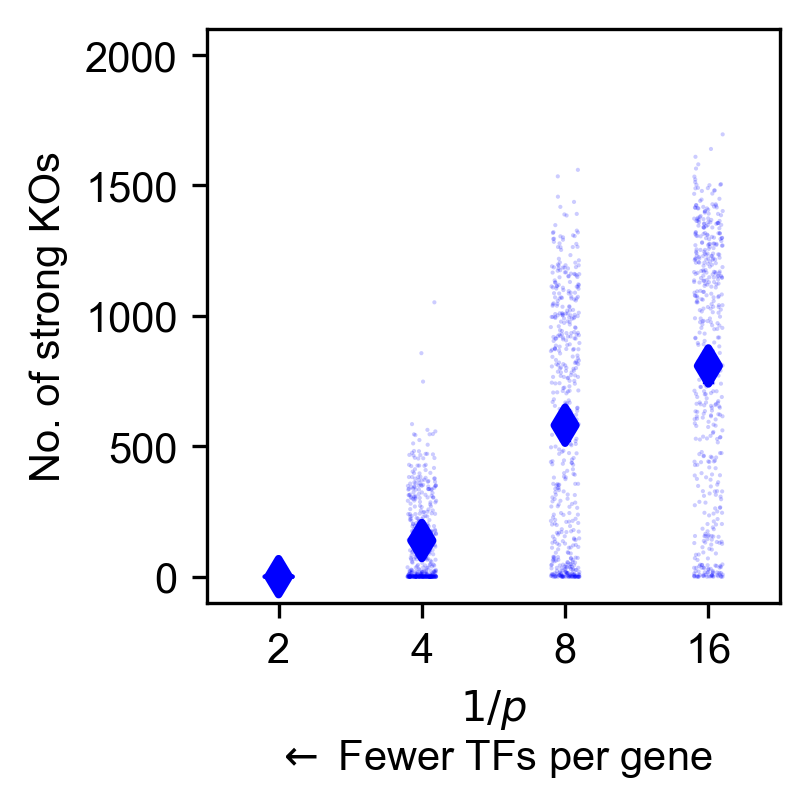

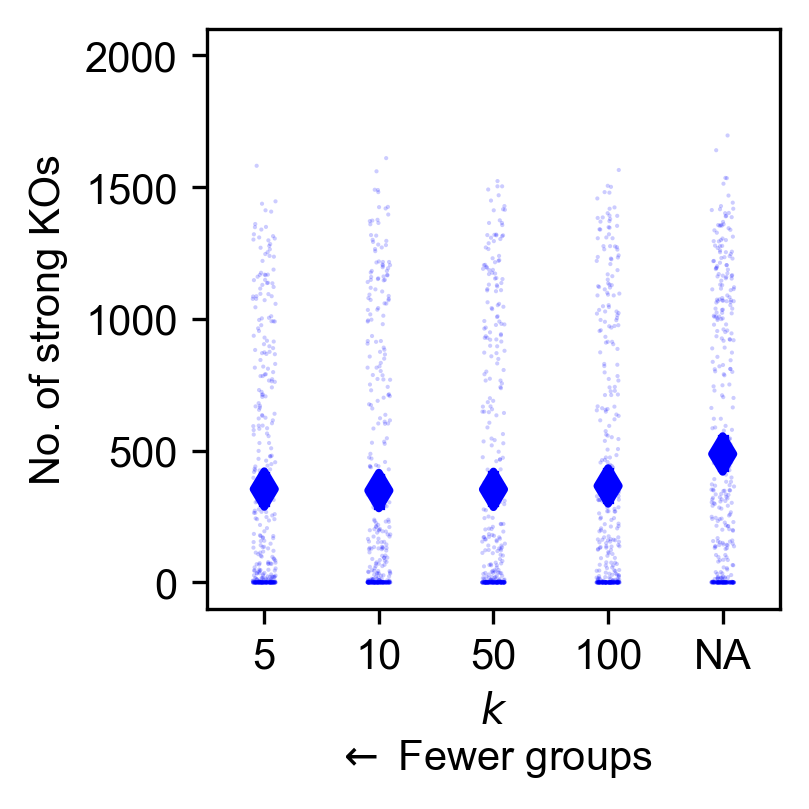

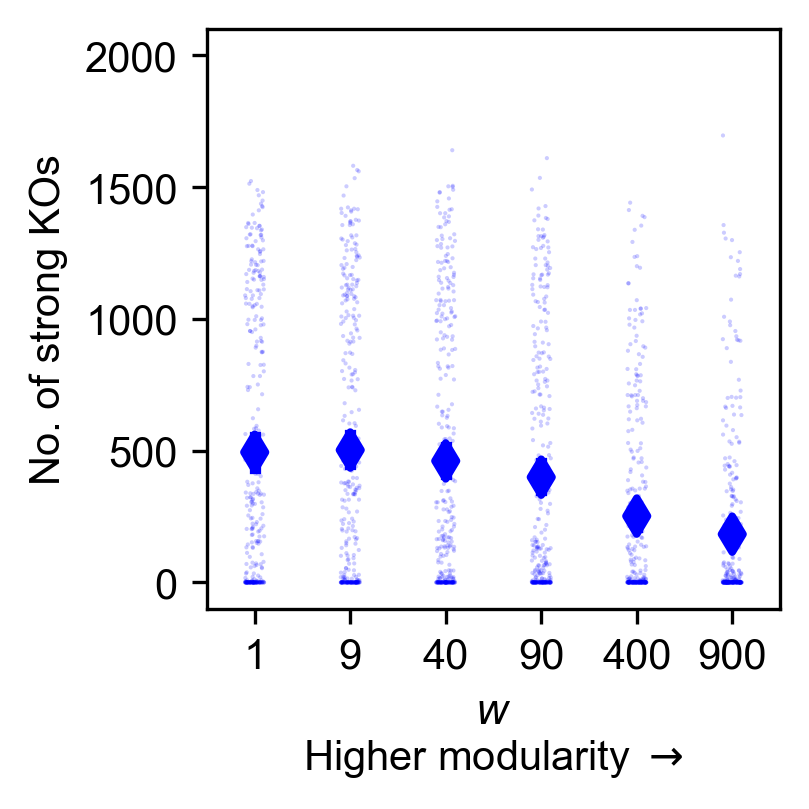

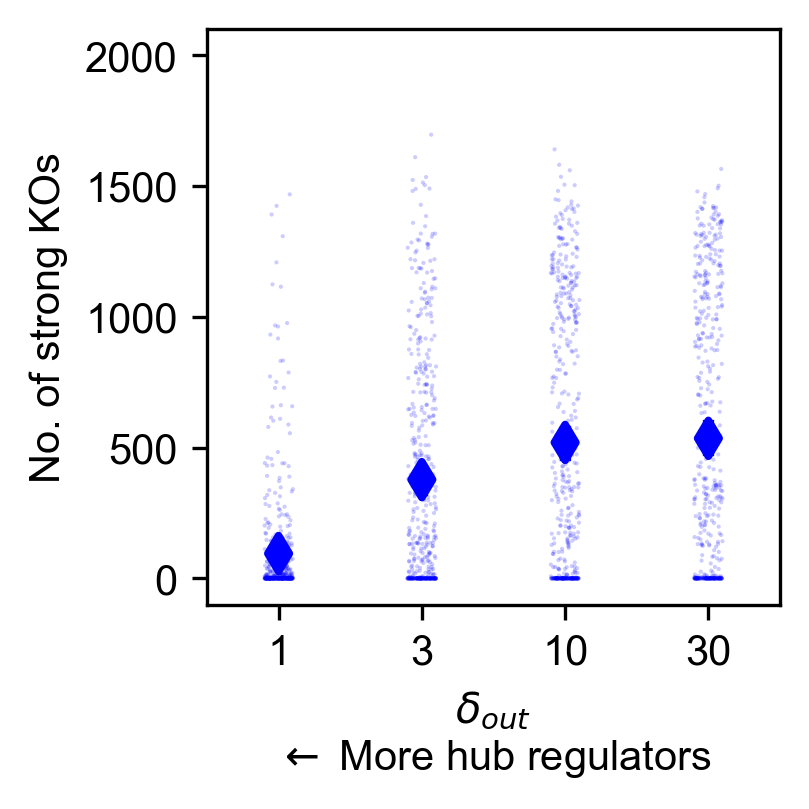

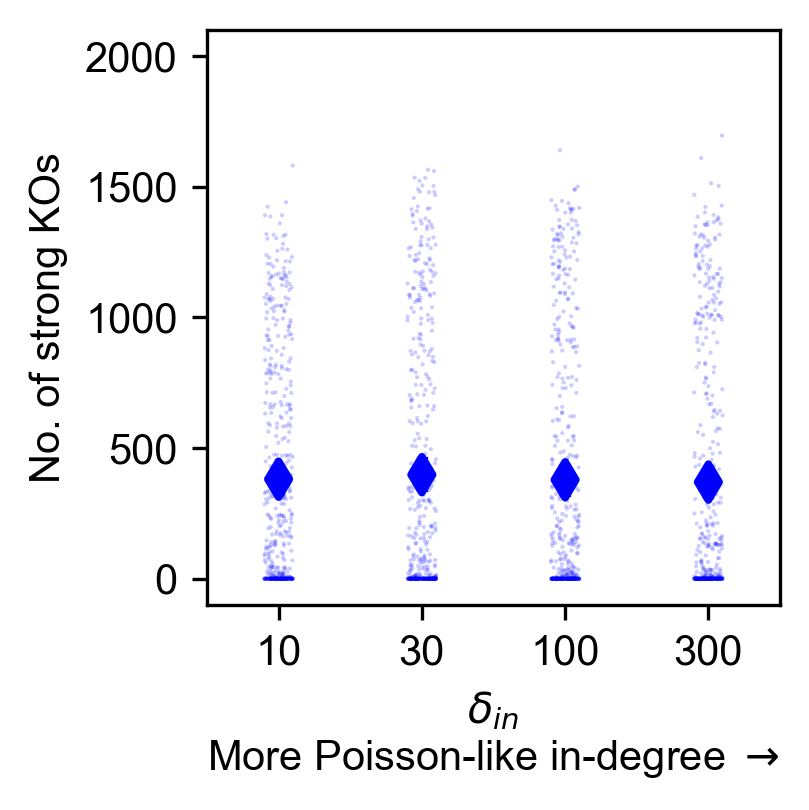

In [19]:
props=['r','k_adj','w','delta_out','delta_in']
names=[r'$1/p$'+'\n'+r'$\leftarrow$'+' Fewer TFs per gene', 
       r'$k$'+'\n'+r'$\leftarrow$'+' Fewer groups', 
       r'$w$'+'\nHigher modularity '+r'$\rightarrow$', 
       r'$\delta_{out}$'+'\n'+r'$\leftarrow$'+' More hub regulators',
       r'$\delta_{in}$'+'\nMore Poisson-like in-degree '+r'$\rightarrow$',
]

stats=['100kos']
shortlabs=['No. of strong KOs']

for i2,(prop,name) in enumerate(zip(props,names)):
    for i1,(stat, shortlab) in enumerate(zip(stats,shortlabs)):
        fig, ax = plt.subplots(1, 1, figsize=(2.8,2.8), dpi=300);
        fig.set(facecolor='white')
        sns.stripplot(data = networks, 
                      y = stat, 
                      x = prop,
                      orient = 'v',
                      hue = 'delta_out' if prop not in ['delta_out', 'r','w','k_adj','delta_in'] else None,
                      dodge = True,
                      alpha = 0.2, 
                      size = 1,
                      zorder = 1, 
                      color = 'b',
                      ax = ax
        )
        sns.pointplot(data = networks, 
                      y = stat, 
                      x = prop,
                      orient = 'v',
                      estimator = np.mean,
                      hue = 'delta_out' if prop not in ['delta_out', 'r','w','k_adj','delta_in'] else None,
                      dodge = .8 - .8 / 3,
                      errorbar = ('ci', 0.95),
                      scale = 0.9,
                      linestyles = 'none',
                      color = 'b',
                      markers = 'd', 
                      ax = ax
        )
        if prop == 'k_adj':
            ax.set_xticklabels([l if l.get_text() != '2000' else 'NA' for l in ax.get_xticklabels()]);
        ax.set_xlabel(name);
        ax.set_ylabel(shortlab)
        ax.set_ylim(-100, 2100);

        fig.tight_layout();
        plt.savefig('png/split/fig4{}.png'.format('abcde'[i2]));
        fig.show()

In [20]:
networks.query('delta_out==1')['100kos'].describe()

count     480.000000
mean       95.035417
std       227.588192
min         0.000000
25%         0.000000
50%         1.000000
75%        54.000000
max      1468.000000
Name: 100kos, dtype: float64

In [21]:
networks.query('delta_out==1')['100tgs'].describe()

count     480.000000
mean      101.175000
std       157.291249
min         0.000000
25%        38.750000
50%        86.000000
75%       121.250000
max      1991.000000
Name: 100tgs, dtype: float64